In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pymysql
import pandas as pd
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
font_location = 'C:/Windows/Fonts/batang.ttc' # For Windows
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
from wordcloud import WordCloud

In [2]:
db = pymysql.connect(host='localhost', port=3306, user='root',
  passwd='08155', db='webtoon_crawling', charset='utf8')
cursor = db.cursor()

### 1. 테이블 생성

In [5]:
webtoon_table = '''
CREATE TABLE naver_webtoon (
  toon_id VARCHAR(10) NOT NULL,
  title VARCHAR(100) NOT NULL PRIMARY KEY,
  writer VARCHAR(80) NOT NULL,
  genre VARCHAR(150) NOT NULL,
  portal VARCHAR(30)
);
'''
cursor.execute(webtoon_table)

# rating_table = '''
# CREATE TALBE rating (
#   toon_id VARCHAR(50) NOT NULL,
#   rating_times INT UNSIGNED
# );
# '''
# cursor.execute(rating_table)

### 2. 웹툰 목록을 크롤링

In [6]:
html = requests.get('https://comic.naver.com/webtoon/period.nhn?period=2019&view=list')
soup = bs(html.text, 'html.parser')
html.close()

subject_list = soup.findAll('td', {'class': 'subject'})
# 테이블에 넣을 데이터를 저장하는 리스트
id_list, title_list, writer_list, genre_list = list(), list(), list(), list()
# 2019년 작품만을 추리기 위해 필요한 리스트
start_date_list = ()

all_id_list = [row.find('a')['href'].split('=')[1] for row in subject_list]

for i in range(len(all_id_list)):
    res = requests.get('https://comic.naver.com/webtoon/detail.nhn?titleId='
    + all_id_list[i] + '&no=1')
    soup = bs(res.text, 'html.parser')
    if soup.find('dd', {'class': 'date'}) is not None:
        date = soup.find('dd', {'class': 'date'}).text
        title = soup.find('title').text.replace(' :: 네이버 만화', '')
        genre = soup.find('span', {'class': 'genre'}).text.split(',')
        writer = soup.find('span', {'class': 'wrt_nm'}).text.lstrip()
      # 2019년의 작품이 아니고, 여러 작가가 참여한 작품을 제외합니다.
        toon_id = soup.find('meta', {'property': 'og:url'})['content'].split('=')[1].split('&')[0]
        id_list.append(toon_id)
        title_list.append(title)
        writer_list.append(writer)
        genre_list.append(genre)
    res.close()

### 3. naver_webtoon 테이블에 데이터를 삽입

In [9]:
for i in range(len(title_list)):
    insert_sql = """INSERT INTO naver_webtoon VALUES (%s, %s, %s, %s, %s);"""
    cursor.execute(insert_sql, (id_list[i],
    title_list[i], writer_list[i], ''.join(genre_list[i]), 'Naver Webtoon'))

db.commit()

### 4. 최근 5편에 평점을 준 인원을 크롤링해서 평균을 저장

In [ ]:
select_genre = '''
SELECT toon_id FROM naver_webtoon WHERE genre LIKE "%드라마% AND genre LIKE "%판타지%"
'''
cursor.execute(select_genre)
selected_id = cursor.fetchall()
# 작품 5편의 평점을 준 인원의 평균을 저장하는 리스트
avg_rating = list()

for row in selected_id:
    total_num = 0
    res = requests.get('https://comic.naver.com/webtoon/list.nhn?titleId=' + row[0])
    soup = bs(res.text, 'html.parser')
    td_list = soup.select('td.title > a')[:5]
  # 최소한 5편을 올린 작품만 선정했습니다.
    if len(td_list) == 5:
        for i in range(5):
            res2 = requests.get('https://comic.naver.com' + td_list[i]['href'])
            soup2 = bs(res2.text, 'html.parser')
            rated_person = int(soup2.find('span', {'class': 'pointTotalPerson'}).em.text)
            total_num += rating_table
    avg_rating.append(int(total_num / 5))

### 5. rating 테이블에 데이터 삽입

In [ ]:
for i in range(len(selected_id)):
    insert_sql = '''INSERT INTO rating (toon_id, rating_times) VALUES (%s, %s);'''
    cursor.execute(insert_sql, (selected_id[i][0], avg_rating[i]))

### 6. 장르 키워드를 가져오기, 그리고 Counter로 확인

In [3]:
select_webtoon= '''SELECT genre FROM naver_webtoon;'''
cursor.execute(select_webtoon)
webtoon_list = cursor.fetchall()

genre_list, genre_detail_list = list(), list()

for row in webtoon_list:
#     genre_list.append(row[0].split(' ')[0])
    genre = row[0].split(' ')
    genre.pop(0)
    for i in genre: genre_detail_list.append(i)
#     genre_detail_list.append(genre)
#     for i in row[0].split(' '): 
#         keywords_list.append(i)


# keywords_counter = Counter(keywords_list)
# keywords_sum, keywords_name = list(), list()
# for i in keywords_counter.most_common():
#     keywords_name.append(i[0])
#     keywords_sum.append(i[1])

In [5]:
Counter(genre_detail_list)

Counter({'스릴러': 56,
         '개그': 76,
         '액션': 80,
         '드라마': 179,
         '일상': 74,
         '판타지': 141,
         '로맨스': 84,
         '감성': 45,
         '시대극': 15,
         '스포츠': 9})

In [4]:
Counter(genre_list)
# 스토리': 293, '옴니버스': 15, '에피소드': 52

Counter()

In [18]:
# 중복 확인
## https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them/9835819
[item for item, count in Counter(title_list).items() if count > 1]

[]

### 7. 데이터프레임, 막대그래프, 워드 클라우드로 시각화

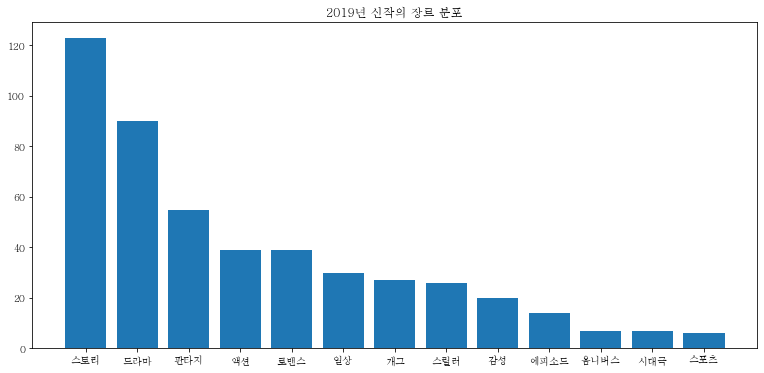

In [23]:
plt.figure(figsize = (13, 6))
plt.title('2019년 신작의 장르 분포')
plt.bar(keywords_name, keywords_sum)
plt.show()

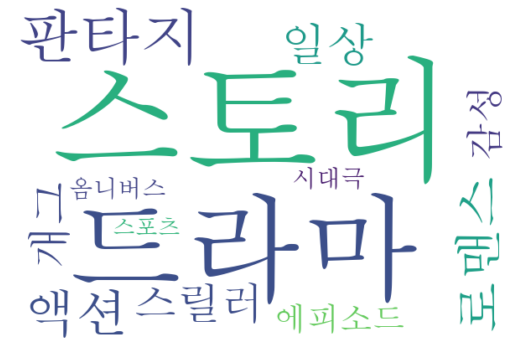

In [26]:
cloud = WordCloud(
    font_path = font_location,
    width = 600,
    height = 400,
    background_color = 'white'
)

cloud = cloud.generate_from_frequencies(keywords_counter)

plt.figure(figsize = (9, 9))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### 8. naver_webtoon과 rating 테이블을 데이터프레임으로 표시하기

In [27]:
select_result = '''
SELECT A.title AS 작품명, A.writer AS 작가, A.genre AS 장르, B.rating_times AS 평가인원
FROM naver_webtoon A JOIN rating AS B ON A.toon_id = B.toon_id
ORDER BY B.rating_times DESC;'''

cursor.execute(select_result)
all_result = list(cursor.fetchall()[:10])

df = pd.DataFrame(all_result, columns = ['작품명', '작가', '장르', '평가인원'])
df

,작품명,작가,장르,평가인원
0,맘마미안,미티 / 구구,스토리 판타지 드라마 감성,22540
1,이두나!,민송아,스토리 개그 드라마 로맨스,18749
2,칼가는 소녀,오리,에피소드 드라마 로맨스 감성,18637
3,이제 곧 죽습니다,이원식 / 꿀찬,스토리 드라마,17486
4,백수세끼,치즈,스토리 일상 드라마 로맨스,16836
5,겟백,세윤,에피소드 액션 드라마 스릴러,15065
6,구름이 피워낸 꽃,비온후,스토리 드라마 로맨스 감성 시대극,14807
7,화양연화 Pt.0 ＜SAVE ME＞,Big Hit Ent. / LICO,스토리 판타지 드라마,13887
8,합격시켜주세용,이온,스토리 일상 판타지,13284
9,인어를 위한 수영교실,용찬,스토리 판타지 드라마 로맨스,12909
